# Phase 2: Model Training with Transfer Learning

**Project:** AI-Powered Pneumonia Detection from Chest X-Rays  
**Author:** Georgios Kitsakis  
**Date:** 2025-10-29

## Objectives
1. Use pre-trained ResNet50 (transfer learning)
2. Fine-tune for pneumonia detection
3. Track metrics (loss, accuracy, precision, recall)
4. Save best model checkpoint
5. Generate confusion matrix and evaluation metrics
6. Achieve 90-95% accuracy

## 1. Import Libraries and Load Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"PyTorch Version: {torch.__version__}")

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Using device: cpu
PyTorch Version: 2.8.0+cpu


## 2. Recreate Dataset and DataLoaders

We'll reuse the code from Phase 1 to load our data.

In [2]:
# Dataset paths
BASE_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0  # Set to 0 for Windows compatibility
NUM_EPOCHS = 10  # Fewer epochs with transfer learning
LEARNING_RATE = 0.0001

print(f"Training Configuration:")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")

Training Configuration:
  Image Size: 224x224
  Batch Size: 32
  Epochs: 10
  Learning Rate: 0.0001


In [3]:
# Transforms - ResNet expects 3 channels and ImageNet normalization
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path):
                continue
                
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.jpeg', '.jpg', '.png')):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets
print("\nLoading datasets...")
train_dataset = ChestXRayDataset(TRAIN_DIR, transform=train_transform)
val_dataset = ChestXRayDataset(VAL_DIR, transform=val_test_transform)
test_dataset = ChestXRayDataset(TEST_DIR, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} images ({len(train_loader)} batches)")
print(f"  Val: {len(val_dataset)} images ({len(val_loader)} batches)")
print(f"  Test: {len(test_dataset)} images ({len(test_loader)} batches)")


Loading datasets...

Dataset sizes:
  Train: 5216 images (163 batches)
  Val: 16 images (1 batches)
  Test: 624 images (20 batches)


## 3. Load Pre-trained ResNet50

Transfer learning: Use ResNet50 trained on ImageNet, freeze early layers, fine-tune last layers.

In [4]:
# Load pre-trained ResNet50
print("Loading pre-trained ResNet50...")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze early layers
print("Freezing early layers...")
for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)  # 2 classes
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: ResNet50 (Transfer Learning)")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters: {total_params - trainable_params:,}")

Loading pre-trained ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\admin/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:04<00:00, 24.8MB/s]


Freezing early layers...

Model: ResNet50 (Transfer Learning)
Total Parameters: 24,033,090
Trainable Parameters: 15,489,794
Frozen Parameters: 8,543,296


## 4. Training Setup

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Training Setup:")
print(f"  Loss: Cross Entropy")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Scheduler: ReduceLROnPlateau")

Training Setup:
  Loss: Cross Entropy
  Optimizer: Adam (lr=0.0001)
  Scheduler: ReduceLROnPlateau


## 5. Training Functions

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """
    Validate for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("Training and validation functions defined.")

Training and validation functions defined.


## 6. Train the Model

In [7]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = '../models/resnet50_pneumonia.pth'

print("\n" + "="*60)
print("Starting Training - ResNet50 Transfer Learning")
print("="*60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

elapsed_time = time.time() - start_time

print("\n" + "="*60)
print("Training Complete!")
print("="*60)
print(f"Total Time: {elapsed_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Starting Training - ResNet50 Transfer Learning

Epoch [1/10]


  Train Loss: 0.2439 | Train Acc: 87.42%
  Val Loss:   0.4285 | Val Acc:   75.00%
  ✓ Best model saved! (Val Acc: 75.00%)

Epoch [2/10]


  Train Loss: 0.1021 | Train Acc: 96.20%
  Val Loss:   0.7562 | Val Acc:   62.50%

Epoch [3/10]


  Train Loss: 0.0722 | Train Acc: 97.43%
  Val Loss:   0.2599 | Val Acc:   87.50%
  ✓ Best model saved! (Val Acc: 87.50%)

Epoch [4/10]


  Train Loss: 0.0673 | Train Acc: 97.26%
  Val Loss:   0.4046 | Val Acc:   81.25%

Epoch [5/10]


  Train Loss: 0.0520 | Train Acc: 98.08%
  Val Loss:   0.4251 | Val Acc:   81.25%

Epoch [6/10]


  Train Loss: 0.0393 | Train Acc: 98.56%
  Val Loss:   0.7727 | Val Acc:   75.00%

Epoch [7/10]


  Train Loss: 0.0398 | Train Acc: 98.47%
  Val Loss:   0.4717 | Val Acc:   75.00%

Epoch [8/10]


  Train Loss: 0.0273 | Train Acc: 99.06%
  Val Loss:   0.4830 | Val Acc:   75.00%

Epoch [9/10]


  Train Loss: 0.0255 | Train Acc: 99.08%
  Val Loss:   0.6590 | Val Acc:   81.25%

Epoch [10/10]


  Train Loss: 0.0215 | Train Acc: 99.25%
  Val Loss:   0.6189 | Val Acc:   81.25%

Training Complete!
Total Time: 226.48 minutes
Best Validation Accuracy: 87.50%


## 7. Visualize Training

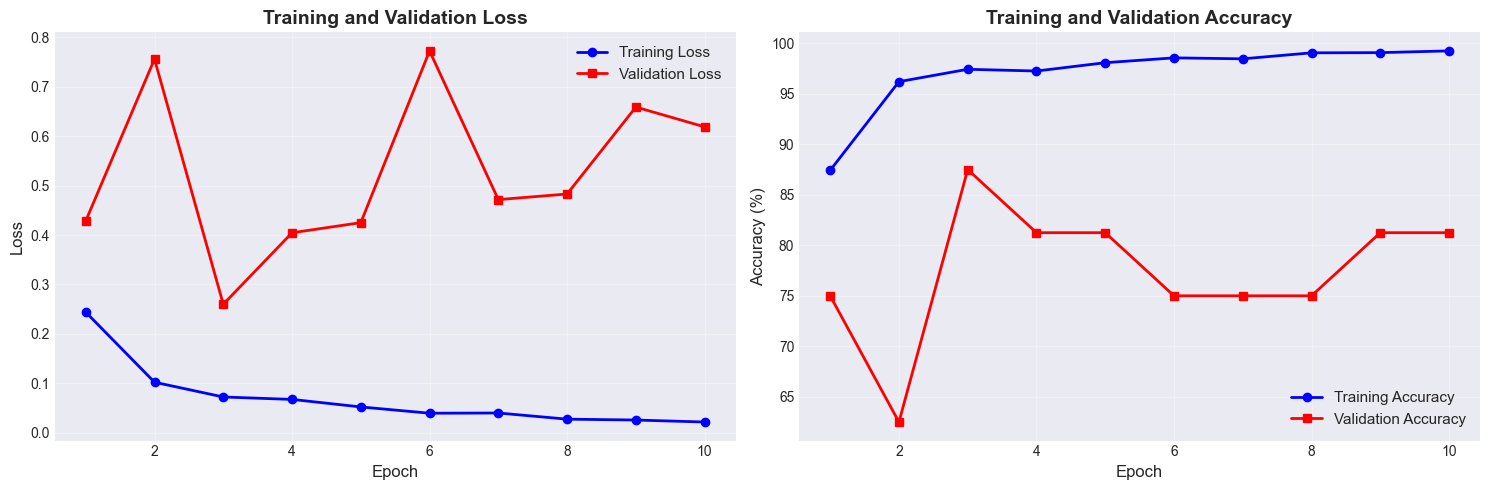

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, NUM_EPOCHS + 1)

# Loss
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o')
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2, marker='o')
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2, marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Test Evaluation with Confusion Matrix

Loaded best model from epoch 3 (Val Acc: 87.50%)


Testing: 100%|██████████| 20/20 [02:02<00:00,  6.10s/it]


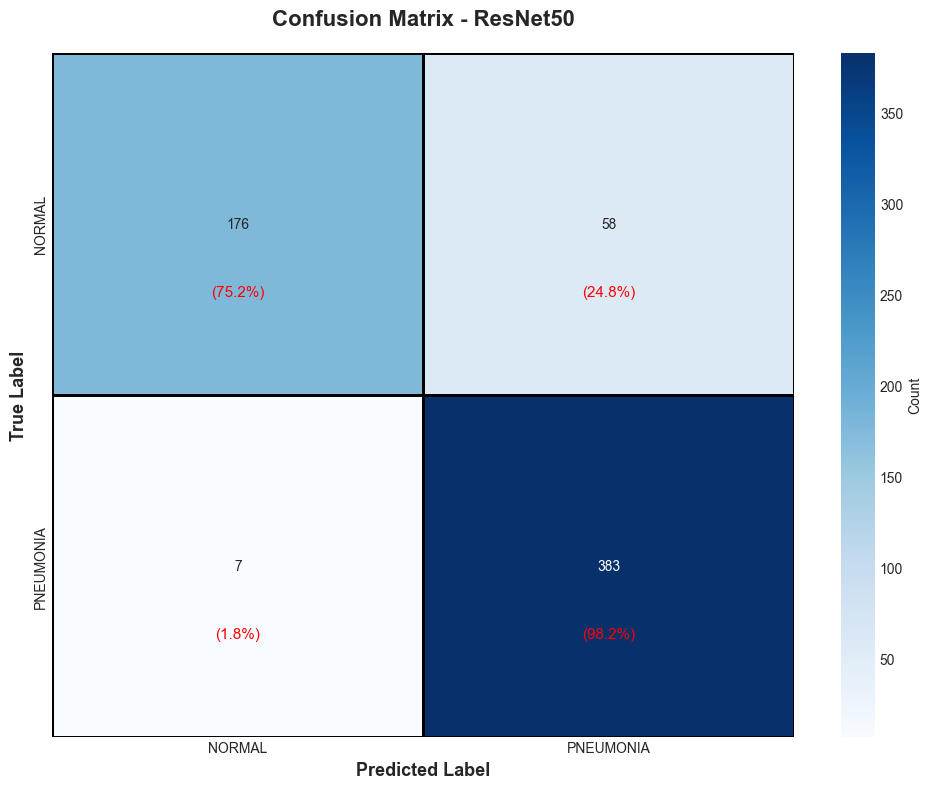


Test Set Evaluation
Test Accuracy: 89.58%

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9617    0.7521    0.8441       234
   PNEUMONIA     0.8685    0.9821    0.9218       390

    accuracy                         0.8958       624
   macro avg     0.9151    0.8671    0.8830       624
weighted avg     0.9035    0.8958    0.8927       624



In [9]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} (Val Acc: {checkpoint['val_acc']:.2f}%)")

# Evaluate on test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_acc = accuracy_score(all_labels, all_predictions) * 100

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = ['NORMAL', 'PNEUMONIA']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=1, linecolor='black')
plt.title('Confusion Matrix - ResNet50', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')

# Add percentages
for i in range(len(class_names)):
    for j in range(len(class_names)):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=11, color='red')

plt.tight_layout()
plt.savefig('../reports/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
print(f"\n{'='*60}")
print(f"Test Set Evaluation")
print(f"{'='*60}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4))
print(f"{'='*60}")

## 9. Summary

In [10]:
print("\n" + "="*60)
print("PHASE 2 COMPLETE: Transfer Learning with ResNet50")
print("="*60)
print("\n✓ ResNet50 model fine-tuned")
print("✓ Model trained for", NUM_EPOCHS, "epochs")
print("✓ Best model saved")
print("✓ Training curves visualized")
print("✓ Confusion matrix generated")
print("✓ Test evaluation complete")
print("\nResults:")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Training Time: {elapsed_time/60:.2f} minutes")
print("\nNext Phase: Grad-CAM for Explainability")
print("="*60)


PHASE 2 COMPLETE: Transfer Learning with ResNet50

✓ ResNet50 model fine-tuned
✓ Model trained for 10 epochs
✓ Best model saved
✓ Training curves visualized
✓ Confusion matrix generated
✓ Test evaluation complete

Results:
  Best Validation Accuracy: 87.50%
  Test Accuracy: 89.58%
  Trainable Parameters: 15,489,794
  Training Time: 226.48 minutes

Next Phase: Grad-CAM for Explainability
